
TENTATIVO CON EVERY VISIT


********** Training number 0 **********

Episode 0, epsilon 1.0000, reward 0.00
Episode 1000, epsilon 0.9996, reward 0.00
Episode 2000, epsilon 0.6988, reward 1.00
Episode 3000, epsilon 0.5227, reward 0.00
Episode 4000, epsilon 0.3978, reward 1.00
Episode 5000, epsilon 0.3009, reward 0.00
Episode 6000, epsilon 0.2218, reward 1.00
Episode 7000, epsilon 0.1548, reward 1.00
Episode 8000, epsilon 0.0969, reward 1.00
Episode 9000, epsilon 0.0457, reward 1.00
Episode 9999, epsilon 0.0100, reward 1.00

********** Training number 1 **********

Episode 0, epsilon 1.0000, reward 0.00
Episode 1000, epsilon 0.9996, reward 0.00
Episode 2000, epsilon 0.6988, reward 1.00
Episode 3000, epsilon 0.5227, reward 0.00
Episode 4000, epsilon 0.3978, reward 0.00
Episode 5000, epsilon 0.3009, reward 0.00
Episode 6000, epsilon 0.2218, reward 1.00
Episode 7000, epsilon 0.1548, reward 0.00
Episode 8000, epsilon 0.0969, reward 1.00
Episode 9000, epsilon 0.0457, reward 1.00
Episode 9999

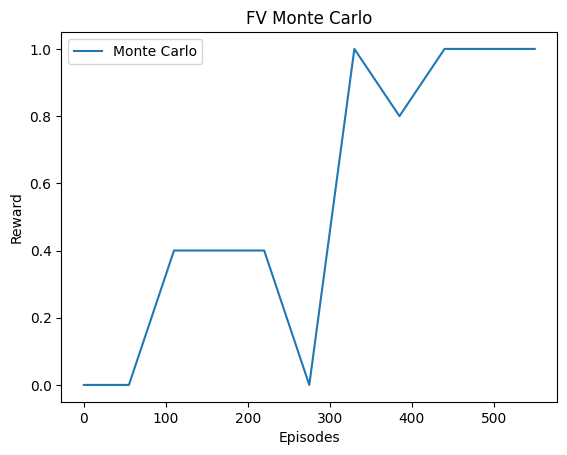


Testing the greedy policy:
Episode 0, reward 1.0
Episode 1, reward 1.0
Episode 2, reward 1.0
Episode 3, reward 1.0
Episode 4, reward 1.0
Average score: 1.0
Testing the policy with epsilon = 0.1
Episode 0, reward 0.0
Episode 1, reward 1.0
Episode 2, reward 1.0
Episode 3, reward 1.0
Episode 4, reward 1.0
Average score: 0.8


In [5]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt

# Create the environment
def create_env():
    return gym.make('FrozenLake-v1', is_slippery=False)  # or True, depending on your use case

# Initialize Q-table
def initialize_q_table(env):
    number_of_states = env.observation_space.n
    number_of_actions = env.action_space.n
    return np.zeros((number_of_states, number_of_actions))

# Decay function for epsilon
def decay_function(episode, total_train_episodes, min_epsilon=0.01):
    return max(min_epsilon, min(1.0, 1.0 - np.log10((episode + 1) / (total_train_episodes * 0.1))))

# Choose action based on epsilon-greedy policy (Behavior Policy)
def choose_action(q_table, state, epsilon, env):
    if np.random.random() <= epsilon:
        return env.action_space.sample()  # Exploration
    else:
        return np.argmax(q_table[state])  # Exploitation

# Generate an episode
def generate_episode(epsilon, q_table, env, max_env_steps):
    state = env.reset()
    total_reward = 0
    done = False
    trajectory = []
    
    for step in range(max_env_steps):
        if isinstance(state, tuple):
            state = state[0]

        action = choose_action(q_table, state, epsilon, env)
        new_state, reward, done, info, _ = env.step(action)
        trajectory.append((state, action, reward))
        state = new_state
        total_reward += reward
        if done:
            break
    
    return trajectory, total_reward

# Off-Policy Monte Carlo with Importance Sampling
def off_policy_monte_carlo_every_visit(env, total_train_episodes, gamma, max_epsilon, min_epsilon):
    q_table = initialize_q_table(env)
    c_table = np.zeros_like(q_table)  # C table for accumulating weights
    rewards = []
    
    max_env_steps = env.spec.max_episode_steps
    
    for episode in range(total_train_episodes):
        epsilon = decay_function(episode, total_train_episodes, min_epsilon)
        trajectory, total_reward = generate_episode(epsilon, q_table, env, max_env_steps)
        g = 0
        w = 1  # Initial weight
        
        for t in reversed(range(len(trajectory))):
            state, action, reward = trajectory[t]
            g = gamma * g + reward
            c_table[state, action] += w
            q_table[state, action] += (w / c_table[state, action]) * (g - q_table[state, action])
            
            # If the action taken is not the one that would have been taken by the greedy policy, break
            if action != np.argmax(q_table[state]):
                break
            
            w *= 1.0 / (epsilon / env.action_space.n)  # Update weight
        
        if episode % 50 == 0:
            rewards.append(total_reward)
            print(f"Episode {episode}, epsilon {epsilon:.4f}, reward {total_reward:.2f}")
    
    rewards.append(total_reward)
    print(f"Episode {episode}, epsilon {epsilon:.4f}, reward {total_reward:.2f}")
    return q_table, rewards

# Off-Policy Monte Carlo with Importance Sampling using First-Visit
def off_policy_monte_carlo_first_visit(env, total_train_episodes, gamma, max_epsilon, min_epsilon):
    q_table = initialize_q_table(env)
    c_table = np.zeros_like(q_table)  # C table for accumulating weights
    rewards = []
    
    max_env_steps = env.spec.max_episode_steps
    
    for episode in range(total_train_episodes):
        epsilon = decay_function(episode, total_train_episodes, min_epsilon)
        trajectory, total_reward = generate_episode(epsilon, q_table, env, max_env_steps)
        g = 0
        w = 1  # Initial weight
        first_visit_check = set()  # Set to keep track of state-action pairs visited in this episode

        for t in reversed(range(len(trajectory))):
            state, action, reward = trajectory[t]
            g = gamma * g + reward

            # Update Q-table only on the first visit to a state-action pair in this episode
            if (state, action) not in first_visit_check:
                first_visit_check.add((state, action))
                c_table[state, action] += w
                q_table[state, action] += (w / c_table[state, action]) * (g - q_table[state, action])
                
                # If the action taken is not the one that would have been taken by the greedy policy, break
                if action != np.argmax(q_table[state]):
                    break

                w *= 1.0 / (epsilon / env.action_space.n)  # Update weight
        
        # if episode % 50 == 0:
        if episode % 1000 == 0:
            rewards.append(total_reward)
            print(f"Episode {episode}, epsilon {epsilon:.4f}, reward {total_reward:.2f}")
    
    rewards.append(total_reward)
    print(f"Episode {episode}, epsilon {epsilon:.4f}, reward {total_reward:.2f}")
    return q_table, rewards


# Plotting the training rewards
def plot_rewards(rewards, title, save_path):
    x = np.linspace(0, len(rewards) * 50, len(rewards))
    plt.plot(x, rewards, label='Monte Carlo')
    plt.title(title)
    plt.xlabel('Episodes')
    plt.ylabel('Reward')
    plt.legend()
    plt.savefig(save_path)
    plt.show()

# Testing the policy
def test_policy_greedy(env, q_table, num_episodes=10):
    print("\nTesting the greedy policy:")
    rewards = []
    max_env_steps = env.spec.max_episode_steps
    
    for episode in range(num_episodes):
        state = env.reset()
        total_rewards = 0
        done = False
        
        for step in range(max_env_steps):
            if isinstance(state, tuple):
                state = state[0]

            action = np.argmax(q_table[state])
            state, reward, done, info, _ = env.step(action)
            total_rewards += reward
            env.render()
            if done:
                env.render()
                break
        
        rewards.append(total_rewards)
        print(f"Episode {episode}, reward {total_rewards}")
    
    print(f"Average score: {np.mean(rewards)}")

    # Testing the policy with an epsilon-greedy approach
def test_policy_epsilon(env, q_table, num_episodes=10, epsilon=0.1):
    print(f"Testing the policy with epsilon = {epsilon}")
    rewards = []
    max_env_steps = env.spec.max_episode_steps
    
    for episode in range(num_episodes):
        state = env.reset()
        total_rewards = 0
        done = False
        
        for step in range(max_env_steps):
            if isinstance(state, tuple):
                state = state[0]
            
            # Use epsilon-greedy for testing
            if np.random.random() < epsilon:
                action = env.action_space.sample()  # Exploration
            else:
                action = np.argmax(q_table[state])  # Exploitation

            state, reward, done, info, _ = env.step(action)
            total_rewards += reward
            env.render()
            if done:
                env.render()
                break
        
        rewards.append(total_rewards)
        print(f"Episode {episode}, reward {total_rewards}")
    
    print(f"Average score: {np.mean(rewards)}")

# Main code
if __name__ == "__main__":
    n_times = 5
    total_train_episodes = 10000
    gamma = 0.99
    max_epsilon = 1.0
    min_epsilon = 0.01

    env = create_env()

    MC_tables = []
    MC_rewards = []
    
    print(f"\nTENTATIVO CON EVERY VISIT\n")
    
    for number in range(n_times):
        print(f"\n********** Training number {number} **********\n")
        q_table, rewards = off_policy_monte_carlo_first_visit(env, total_train_episodes, gamma, max_epsilon, min_epsilon)
        # q_table, rewards = off_policy_monte_carlo_every_visit(env, total_train_episodes, gamma, max_epsilon, min_epsilon)
        MC_tables.append(q_table)
        MC_rewards.append(rewards)

    MC_mean = np.mean(np.array(MC_rewards), axis=0)
    MC_mean_tables = np.mean(np.array(MC_tables), axis=0)
    # np.save('MC_mean_EV.npy', MC_mean)
    # np.save('MC_tables_EV.npy', MC_tables)
    np.save('MC_mean_FV.npy', MC_mean)
    np.save('MC_tables_FV.npy', MC_tables)

    # plot_rewards(MC_mean, 'EV Monte Carlo', 'OFF/imgs/EV_rewards.png')
    plot_rewards(MC_mean, 'FV Monte Carlo', 'OFF/imgs/FV_rewards.png')

    # Load Q-tables and test
    # q_tables = np.load('ON/models/MC_tables_EV.npy', allow_pickle=True)
    # q_tables = np.load('ON/models/MC_tables_FV.npy', allow_pickle=True)
    # q_table = np.load('ON/models/MC_tables_EV.npy', allow_pickle=True)
    q_table = np.load('ON/models/MC_tables_FV.npy', allow_pickle=True)
    #q_table = q_tables[0]
    env = gym.make('FrozenLake-v1', is_slippery=False, render_mode="human")
    test_policy_greedy(env, q_table, num_episodes=5)
    test_policy_epsilon(env, q_table, num_episodes=5, epsilon=0.1)
    
    env.close()


[[0.2845521  0.57174957 0.26386916 0.26716235]
 [0.12203504 0.         0.38470085 0.12233613]
 [0.16793454 0.47814668 0.17074089 0.2187841 ]
 [0.26179338 0.         0.08001639 0.09083652]
 [0.29618666 0.6794529  0.         0.29220738]
 [0.         0.         0.         0.        ]
 [0.         0.72085966 0.         0.30321253]
 [0.         0.         0.         0.        ]
 [0.42780161 0.         0.78195185 0.36403254]
 [0.4880243  0.84030336 0.69806661 0.        ]
 [0.52490579 0.92596022 0.         0.4509946 ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.72624404 0.94925563 0.61339895]
 [0.74758211 0.90145262 1.         0.72180825]
 [0.         0.         0.         0.        ]]


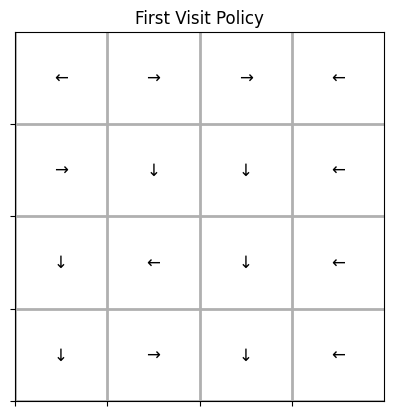

[[0.22520195 0.45246426 0.28455043 0.21909001]
 [0.18751601 0.         0.32861094 0.13651518]
 [0.17398378 0.36262404 0.1588719  0.17756757]
 [0.24323246 0.         0.05447233 0.06639888]
 [0.23226103 0.53497184 0.         0.24365497]
 [0.         0.         0.         0.        ]
 [0.         0.71259405 0.         0.200461  ]
 [0.         0.         0.         0.        ]
 [0.35568433 0.         0.6469932  0.23728651]
 [0.39482318 0.69839061 0.68329295 0.        ]
 [0.51076199 0.93129496 0.         0.5143215 ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.6991082  0.93682452 0.42345704]
 [0.81837937 0.86858803 1.         0.73189209]
 [0.         0.         0.         0.        ]]


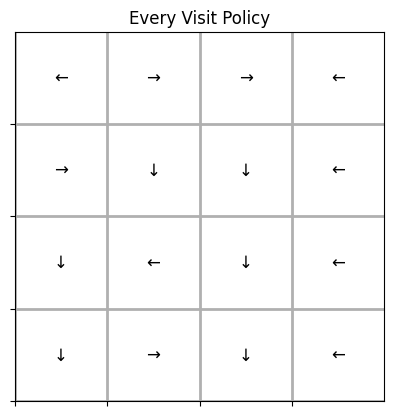

In [9]:
import numpy as np
import matplotlib.pyplot as plt

def plot_policy(q_table, grid_size=(4, 4), title='Policy', save_path=None):
    """
    Plots the policy learned by the Q-table on a grid using text labels for directions.

    Parameters:
        q_table (numpy.ndarray): The Q-table from which to derive the policy.
        grid_size (tuple): The size of the grid representing the environment (default is (4, 4)).
    """
    # Define direction labels
    direction_labels = {
        0: '←',  # left
        1: '↓',  # down
        2: '→',  # right
        3: '↑'   # up
    }
    
    print(q_table)
    policy = np.argmax(q_table, axis=1).reshape(grid_size)
    
    # Set up the grid
    fig, ax = plt.subplots()
    ax.set_xticks(np.arange(grid_size[1]))
    ax.set_yticks(np.arange(grid_size[0]))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
    # Create grid
    ax.grid(which='both', linestyle='-', linewidth=2)
    
    # Plot direction labels
    for i in range(grid_size[0]):
        for j in range(grid_size[1]):
            action = policy[i, j]
            direction = direction_labels[action]
            ax.text(j + 0.5, i + 0.5, direction, 
                    ha='center', va='center', fontsize=12, color='black')

    # Set the aspect of the plot to equal
    ax.set_aspect('equal')
    ax.set_title(title)
    ax.set_xlim(0, grid_size[1])
    ax.set_ylim(0, grid_size[0])
    plt.savefig(save_path)
    plt.show()

# Usage example:
if __name__ == "__main__":
    # Assuming you have already saved your Q-tables as 'MC_tables.npy'
    FV_q_table = np.load('ON/models/MC_tables_FV.npy', allow_pickle=True)
    EV_q_table = np.load('ON/models/MC_tables_EV.npy', allow_pickle=True)
    
    plot_policy(FV_q_table, title='First Visit Policy', save_path='OFF/imgs/FV_policy.png')
    plot_policy(EV_q_table, title='Every Visit Policy', save_path='OFF/imgs/EV_policy.png')
    #su, giu, sx, dx
    #sx, giu, dx, su
    #2,3,2,1,2,-,2,-,3,-,2,
